# Choroid Plexus and Thalamic Nuclei

## Setup

Formatting

<style>
body, .jp-Notebook {
    font-family: 'Source Sans 3', serif !important;
}


table {
    font-family: 'Source Sans 3', sans-serif;
}

table td, table th {
    text-align: center !important;
}

/* Optional: keep first column left-aligned if it contains labels */
table td:first-child, table th:first-child {
    text-align: left !important;
}
</style>

### Imports

In [2]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process
from statsmodels.stats.multitest import multipletests
from IPython.display import clear_output

import os
import numpy as np
import pyperclip
import statsmodels.api as sm
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess

from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace

In [3]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import utils
from utils import load_df, zscore, get_colors
from my_namespace import *

import regression_utils as regutils
from regression_utils import (
    quick_regression,
    quick_regression2,
    residualize_vars,
    run_regressions,
)

### Load Data

#### Clinical and Volumes

In [4]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/6-Thalamic_nuclei_and_disability"
)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

data = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv", index_col="subid"
)

MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

data_ms = data[MS_patients]
data_ms_z = zscore(data_ms)

resid_data_z = data_ms_z.copy()
resid_data = data_ms.copy()
for var in all_predictors:
    resid_data[var] = utils.residualize_structs(data_ms, var, ["age", "Female", "tiv"])
    resid_data_z[var] = utils.residualize_structs(
        data_ms_z, var, ["age", "Female", "tiv"]
    )


grouped_nuclei = ["medial", "posterior", "ventral", "anterior"]

nuclei_rename_index = {k: f"**{k}**" for k in grouped_nuclei}

### Functions

In [5]:
def run_R_script(p1, p2, p12, nobs):
    """
    Call R script to run Williams-Hotelling test and return p-value.

    Parameters:
    -----------
    p1 : float
        First correlation coefficient
    p2 : float
        Second correlation coefficient
    p12 : float
        Correlation between the two variables
    nobs : int
        Number of observations

    Returns:
    --------
    float
        The p-value from the Williams-Hotelling test
    """
    # Path to the R script (adjust this to where your R script is located)
    r_script_path = (
        "/home/srs-9/Projects/ms_mri/analysis/thalamus/run_williams_hotelling.R"
    )

    # Convert arguments to strings
    args = [str(p1), str(p2), str(p12), str(nobs)]

    # Call R script
    try:
        result = subprocess.run(
            ["Rscript", r_script_path] + args,
            capture_output=True,
            text=True,
            check=True,
        )

        # Parse the output (p-value)
        p_value = float(result.stdout.strip())
        return p_value

    except subprocess.CalledProcessError as e:
        print(f"Error running R script: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        raise
    except ValueError as e:
        print(f"Error parsing R output: {e}")
        print(f"R output was: {result.stdout}")
        raise


def thalamus_influence_analysis(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
        residualized_vars[var] = residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = ["medial", "posterior", "anterior", "ventral"]
    working_structs = structs.copy()

    nuclei_comps = {}
    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"{struct} vs THALAMUS_1"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"{struct} vs THALAMUS_1"] >= 0.05:
            sign = "="
        elif abs(pearson_results[struct][0]) > abs(pearson_results["THALAMUS_1"][0]):
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
                pearson_results[struct1][0],
                pearson_results[struct2][0],
                stats.pearsonr(residualized_vars[struct1], residualized_vars[struct2])[
                    0
                ],
                nobs,
            )
            if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
                sign = "="
            elif abs(pearson_results[struct1][0]) > abs(pearson_results[struct2][0]):
                sign = ">"
            else:
                sign = "<"
            nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}

    return pearson_results, thalamus_comps, nuclei_comps

## Results section 6

**No relationship between clinical disability and regional thalamic atrophy**

In [35]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]

predictors = [
    "CP",
    "cortical_thickness",
    "brain",
    "white",
    "grey",
    "THALAMUS_1",
    "LV_log",
    "thirdV_log",
    "fourthV_log",
    "periCSF",
    "allCSF",
    "CCR", 
    "periCSF_frac"
]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols, inds=display_order).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + age + Female + tiv + dzdur`

| predictor          |    coef |    pval |   p_fdr |     se | ci                |   R2 |
|:-------------------|--------:|--------:|--------:|-------:|:------------------|-----:|
| THALAMUS_1         | -0.2553 | 1.6e-07 | 2e-06   | 0.0479 | [-0.349, -0.161]  | 0.29 |
| cortical_thickness | -0.195  | 8.1e-06 | 5.3e-05 | 0.0432 | [-0.28, -0.11]    | 0.27 |
| thirdV_log         |  0.1718 | 0.00035 | 0.0009  | 0.0476 | [0.0782, 0.265]   | 0.27 |
| periCSF_frac       | -0.169  | 0.0002  | 0.00069 | 0.0451 | [-0.258, -0.0804] | 0.27 |
| CCR                |  0.1654 | 0.00021 | 0.00069 | 0.0443 | [0.0783, 0.252]   | 0.27 |
| allCSF             |  0.1631 | 0.02    | 0.037   | 0.0697 | [0.026, 0.3]      | 0.25 |
| LV_log             |  0.1569 | 0.00084 | 0.0018  | 0.0467 | [0.0652, 0.249]   | 0.26 |
| grey               | -0.092  | 0.069   | 0.099   | 0.0504 | [-0.191, 0.00706] | 0.25 |
| fourthV_log        |  0.0848 | 0.048   | 0.078   | 0.0428 | [0.000675, 0.169] | 0.25 |
| brain              | -0.0666 | 0.16    | 0.21    | 0.0474 | [-0.16, 0.0267]   | 0.25 |
| CP                 |  0.0535 | 0.22    | 0.26    | 0.0438 | [-0.0326, 0.139]  | 0.25 |
| periCSF            |  0.0262 | 0.7     | 0.7     | 0.0675 | [-0.106, 0.159]   | 0.24 |
| white              | -0.0196 | 0.67    | 0.7     | 0.0454 | [-0.109, 0.0696]  | 0.24 |

`SDMT ~ *predictor* + age + Female + tiv + dzdur`

| predictor          |    coef |    pval |   p_fdr |     se | ci                |   R2 |
|:-------------------|--------:|--------:|--------:|-------:|:------------------|-----:|
| THALAMUS_1         |  0.3731 | 4.3e-10 | 2.8e-09 | 0.0584 | [0.258, 0.488]    | 0.25 |
| cortical_thickness |  0.3614 | 9.2e-13 | 1.2e-11 | 0.0491 | [0.265, 0.458]    | 0.25 |
| allCSF             | -0.3351 | 4.5e-06 | 9.7e-06 | 0.0722 | [-0.477, -0.193]  | 0.2  |
| grey               |  0.2896 | 7e-09   | 3e-08   | 0.049  | [0.193, 0.386]    | 0.21 |
| LV_log             | -0.2875 | 5.4e-07 | 1.8e-06 | 0.0565 | [-0.399, -0.176]  | 0.22 |
| periCSF_frac       |  0.2548 | 1.2e-05 | 2e-05   | 0.0576 | [0.142, 0.368]    | 0.21 |
| CCR                | -0.2519 | 1.9e-05 | 2.8e-05 | 0.0583 | [-0.366, -0.137]  | 0.21 |
| thirdV_log         | -0.2432 | 9e-06   | 1.7e-05 | 0.0541 | [-0.35, -0.137]   | 0.2  |
| brain              |  0.2312 | 1.6e-06 | 4.2e-06 | 0.0475 | [0.138, 0.325]    | 0.19 |
| CP                 | -0.1554 | 0.006   | 0.0077  | 0.0562 | [-0.266, -0.0449] | 0.17 |
| periCSF            | -0.1347 | 0.052   | 0.054   | 0.069  | [-0.27, 0.000954] | 0.16 |
| white              |  0.1022 | 0.031   | 0.036   | 0.0472 | [0.0095, 0.195]   | 0.16 |
| fourthV_log        | -0.0957 | 0.054   | 0.054   | 0.0495 | [-0.193, 0.00153] | 0.16 |

In [15]:
res = sm.OLS.from_formula("cortical_thickness ~ CCR_log + CP + age + Female + tiv", data=model_data).fit()
rres = res.get_robustcov_results(cov_type="HC3")
print(rres.summary())

                            OLS Regression Results                            
Dep. Variable:     cortical_thickness   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     62.25
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.56e-49
Time:                        17:51:43   Log-Likelihood:                -544.62
No. Observations:                 467   AIC:                             1101.
Df Residuals:                     461   BIC:                             1126.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0011      0.036      0.031      0.9

In [18]:
res = sm.OLS.from_formula("THALAMUS_1 ~ CCR_log*t2lv_log + age + Female + tiv", data=model_data).fit()
rres = res.get_robustcov_results(cov_type="HC3")
print(rres.summary())

                            OLS Regression Results                            
Dep. Variable:             THALAMUS_1   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     112.7
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           4.36e-87
Time:                        17:55:05   Log-Likelihood:                -440.02
No. Observations:                 467   AIC:                             894.0
Df Residuals:                     460   BIC:                             923.1
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0468      0.030  

### How do thalamic nuclei predict disability?


No thalamic nucleus predicts disability after controlling for global thalamic atrophy

In [36]:
model_data = data_ms_z
save_path = fig_path / "combined_nuclei_thalamus_control_by_struct.xlsx"
covariates = ["THALAMUS_1", "age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]

predictors = ["medial", "posterior", "ventral", "anterior"]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + THALAMUS_1 + age + Female + tiv + dzdur`

| predictor   |    coef |   pval |   p_fdr |     se | ci               |   R2 |
|:------------|--------:|-------:|--------:|-------:|:-----------------|-----:|
| medial      |  0.1351 |   0.25 |    0.51 | 0.1182 | [-0.0971, 0.367] | 0.29 |
| posterior   | -0.093  |   0.48 |    0.55 | 0.1325 | [-0.353, 0.167]  | 0.29 |
| ventral     | -0.0645 |   0.55 |    0.55 | 0.1077 | [-0.276, 0.147]  | 0.29 |
| anterior    | -0.105  |   0.12 |    0.47 | 0.0668 | [-0.236, 0.0261] | 0.29 |

`SDMT ~ *predictor* + THALAMUS_1 + age + Female + tiv + dzdur`

| predictor   |   coef |   pval |   p_fdr |     se | ci               |   R2 |
|:------------|-------:|-------:|--------:|-------:|:-----------------|-----:|
| medial      | 0.0323 |   0.81 |    0.81 | 0.1359 | [-0.235, 0.299]  | 0.25 |
| posterior   | 0.0717 |   0.57 |    0.81 | 0.1264 | [-0.177, 0.32]   | 0.25 |
| ventral     | 0.0548 |   0.61 |    0.81 | 0.107  | [-0.155, 0.265]  | 0.25 |
| anterior    | 0.0661 |   0.27 |    0.81 | 0.0596 | [-0.0509, 0.183] | 0.25 |

In [38]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="CP",
    y="EDSS_sqrt",
    w="t2lv_log",
    m=["CCR_log"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2715   0.2600 0.7415 27.6343    6  445   0.0000

Coefficients

          coeff     se       t      p    LLCI    ULCI
Cons    -0.0096 0.0405 -0.2364 0.8133 -0.0890  0.0698
CP      -0.0681 0.0586 -1.1619 0.2459 -0.1830  0.0468
age      0.2711 0.0538  5.0370 0.0000  0.1656  0.3766
Female  -0.1094 0.0491 -2.2277 0.0264 -0.2057 -0.0132
tiv     -0.1131 0.0478 -2.3672 0.0183 -0.2067 -0.0195
dzdur    0.1999 0.0507  3.9402 0.0001  0.1005  0.2994
CCR_log  0.1925 0.0584  3.2979 0.0011  0.0781  0.3069

-------------------------------------------------------------------------

Outcome = CCR_log 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.5666   0.5588 0.4420 82.9162    7  444   0.0000

Coefficients

              coeff     se       t      p    LLCI   ULCI
Cons         0.0068 0.0338  0.1998 0.

In [25]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="CCR_log",
    y="SDMT",
    w="t2lv_log",
    m=["THALAMUS_1"],
    controls=["age", "Female", "tiv", "periCSF"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = SDMT 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2618   0.2502 0.7514 26.3630    6  446   0.0000

Coefficients

             coeff     se       t      p    LLCI    ULCI
Cons        0.0084 0.0407  0.2060 0.8369 -0.0714  0.0882
CCR_log    -0.1210 0.0600 -2.0165 0.0443 -0.2387 -0.0034
age        -0.2013 0.0477 -4.2188 0.0000 -0.2948 -0.1078
Female      0.0895 0.0491  1.8231 0.0690 -0.0067  0.1856
tiv         0.0962 0.0852  1.1296 0.2593 -0.0707  0.2631
periCSF    -0.0641 0.0670 -0.9556 0.3398 -0.1954  0.0673
THALAMUS_1  0.2742 0.0648  4.2327 0.0000  0.1472  0.4011

-------------------------------------------------------------------------

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.6649   0.6589 0.3382 126.1456    7  445   0.0000

Coefficients

                   coeff     se        t      p    LLCI    ULCI
Cons  

In [43]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="t2lv_log",
    y="EDSS_sqrt",
    m=["cortical_thickness"],
    w="CP",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2807   0.2694 0.7306 29.0076    6  446   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons               -0.0119 0.0402 -0.2966 0.7669 -0.0907  0.0668
t2lv_log            0.0351 0.0482  0.7286 0.4667 -0.0594  0.1297
age                 0.2427 0.0536  4.5268 0.0000  0.1376  0.3478
Female             -0.0831 0.0482 -1.7248 0.0853 -0.1776  0.0113
tiv                -0.0712 0.0484 -1.4717 0.1418 -0.1661  0.0236
dzdur               0.1864 0.0510  3.6513 0.0003  0.0863  0.2864
cortical_thickness -0.1782 0.0519 -3.4338 0.0007 -0.2799 -0.0765

-------------------------------------------------------------------------

Outcome = cortical_thickness 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.4354   0.4252 0.5772 49.0146    7  445   0.0000

Coefficie

In [51]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="CP",
    y="EDSS_sqrt",
    m=["THALAMUS_1"],
    w="t2lv_log",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2966   0.2855 0.7145 31.3407    6  446   0.0000

Coefficients

             coeff     se       t      p    LLCI    ULCI
Cons       -0.0128 0.0397 -0.3224 0.7473 -0.0907  0.0651
CP         -0.0602 0.0498 -1.2085 0.2275 -0.1578  0.0374
age         0.2878 0.0523  5.5069 0.0000  0.1854  0.3902
Female     -0.0711 0.0484 -1.4697 0.1423 -0.1659  0.0237
tiv         0.0393 0.0540  0.7270 0.4676 -0.0666  0.1452
dzdur       0.1478 0.0513  2.8810 0.0042  0.0472  0.2483
THALAMUS_1 -0.2841 0.0545 -5.2141 0.0000 -0.3909 -0.1773

-------------------------------------------------------------------------

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.5739   0.5662 0.4375 85.6115    7  445   0.0000

Coefficients

              coeff     se       t      p    LLCI    ULCI
Cons     

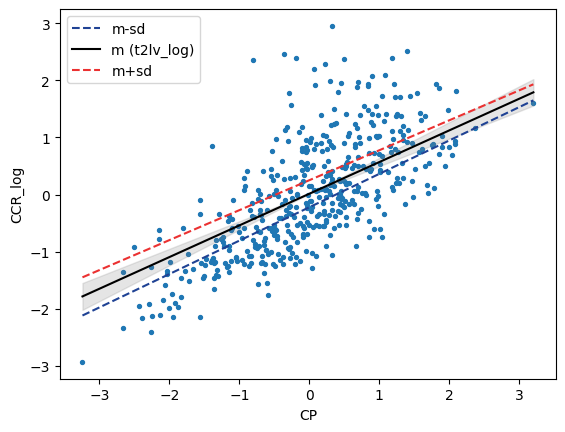

In [45]:
covariates = ["age", "Female", "tiv"]
regutils.plot_moderation(data_ms_z, "CCR_log", "CP", "t2lv_log", covariates)

In [24]:
formula = "THALAMUS_1 ~ CP*t2lv_log + age + Female + tiv"
model = sm.OLS.from_formula(formula, data=data_ms_z).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             THALAMUS_1   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     97.76
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           5.77e-79
Time:                        17:10:28   Log-Likelihood:                -471.99
No. Observations:                 468   AIC:                             958.0
Df Residuals:                     461   BIC:                             987.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0340      0.033      1.021      

### LV expansion and thalamic volumes

Does thalamic volume loss have regional relationships with expansion of the central CSF compartment?

**Steps**

1. Residualize out the effect of age, sex, TIV, and peripheral CSF volume from LV and each of the thalamic nuclei
2. Compute the Pearson correlations (r) between the residualized CP and each of the nuclei as well as the whole thalamus
3. Use the [Williams-Hotelling test](https://rdrr.io/github/bcdudek/bcdstats/man/test2r.t2.html) to compare the sizes of the r's (this procedure was used in Bergsland et al. 2020 as well)

In [24]:
disease_group = "MS"
influenced_var = "EDSS_sqrt"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

covariates = ["periCSF", "age", "Female", "tiv"]
results = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [25]:
pearson_results, thalamus_comps, nuclei_comps = results
display(Markdown(f"##### Patients with {disease_group}"))

display(
    Markdown(
        f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"
    )
)
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### Patients with MS

**Pearson correlations of residualized thalamic nuclei and EDSS_sqrt:**

```visualprolog
THALAMUS_1: r=-0.286, p=5.69e-10
medial: r=-0.242, p=1.80e-07
posterior: r=-0.278, p=1.78e-09
anterior: r=-0.244, p=1.52e-07
ventral: r=-0.264, p=1.26e-08
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
- medial < THALAMUS_1: p=1.49e-02
  posterior = THALAMUS_1: p=6.20e-01
  anterior = THALAMUS_1: p=2.61e-01
  ventral = THALAMUS_1: p=3.17e-01
```



**Comparisons between thalamic nuclei:**

```diff
  medial = posterior: p=1.41e-01
  medial = anterior: p=9.73e-01
  medial = ventral: p=5.23e-01
  posterior = anterior: p=3.87e-01
  posterior = ventral: p=6.75e-01
  anterior = ventral: p=6.29e-01
```


---